In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import pandas as pd
plt.style.use('informes.mplstyle')


df = pd.read_csv(r'Mediciones\Clase 3\PID\PID-2-0.07-2-barrido.csv')
df = df[df['Time'] < 40]

t = df['Time'].values
h = df['Position'].values
P = df['P'].values
I = df['I'].values
D = df['D'].values

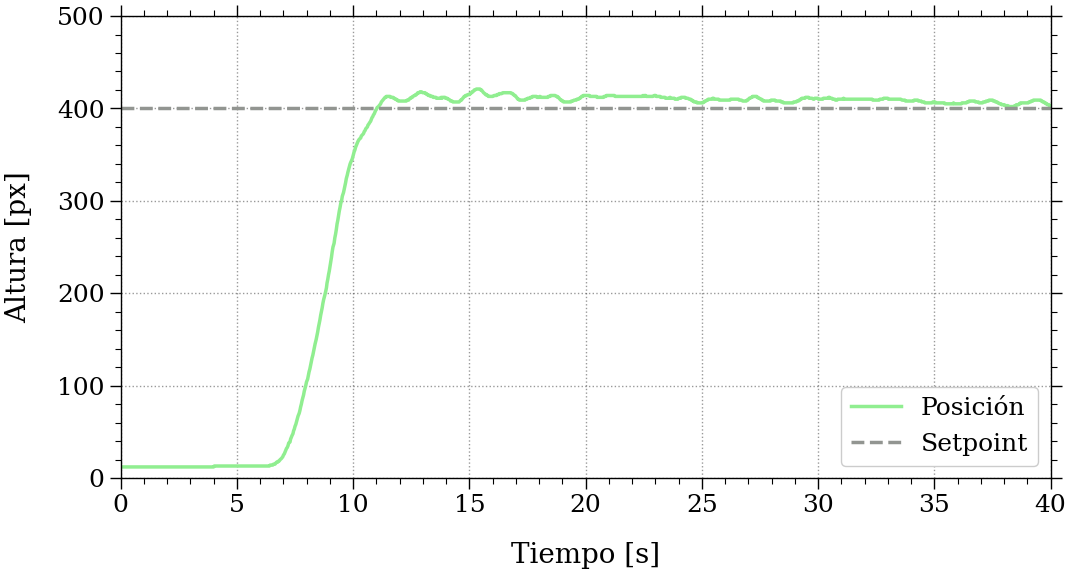

In [3]:
fig, ax = plt.subplots()
ax.set_xlabel('Tiempo [s]')
ax.set_ylabel('Altura [px]')
ax.set_xlim(0, 40)
ax.set_ylim(0, 500)

ax.plot(t, h, label='Posición')
ax.axhline(400, c='C9', ls='--', label='Setpoint')


ax.legend(loc='lower right')
plt.show()

FILTRO IIR (Infinite Impulse Response)

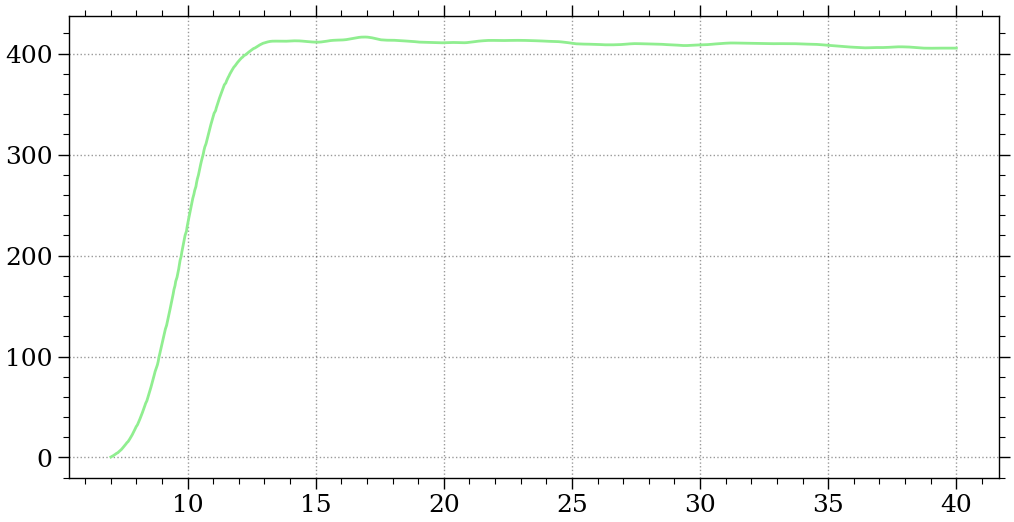

In [73]:
from scipy.signal import lfilter 

n = 60
b = [1.0 / n] * n
a = 1
hh = lfilter(b, a, h)
plt.plot(t, hh, linewidth=2, linestyle="-")  # smooth by filter

FILTRO PASA ALTOS

In [5]:
from scipy.signal import butter,filtfilt
def butter_highpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype = "high", analog = False)
    return b, a

def butter_highpass_filter(data, cutoff, fs, order=5):
    b, a = butter_highpass(cutoff, fs, order=order)
    y = filtfilt(b, a, data)
    return y

27


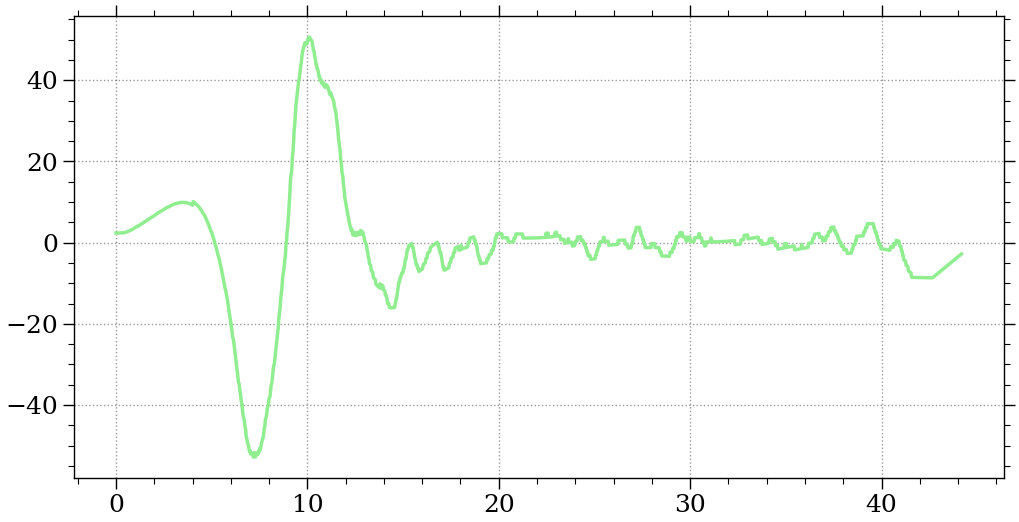

In [6]:
fs = int(len(t)/t[-1])
print(fs)
highpass_h = butter_highpass_filter(h,0.1,fs,2)
fig, ax = plt.subplots()
ax.plot(t,highpass_h)

Text(0.5, 1.0, 'Posición - posición filtrada (no pasa altos)')

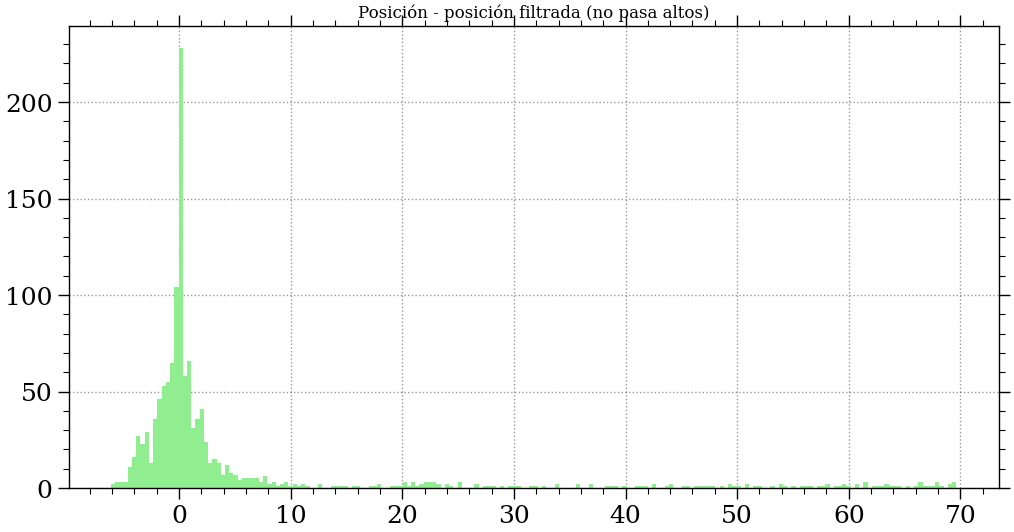

In [7]:
fig, ax = plt.subplots()
noise = h-hh
ax.hist(noise,bins=200)
plt.title(f'Posición - posición filtrada (no pasa altos)')

Text(0.5, 1.0, 'h filtrado pasa alto')

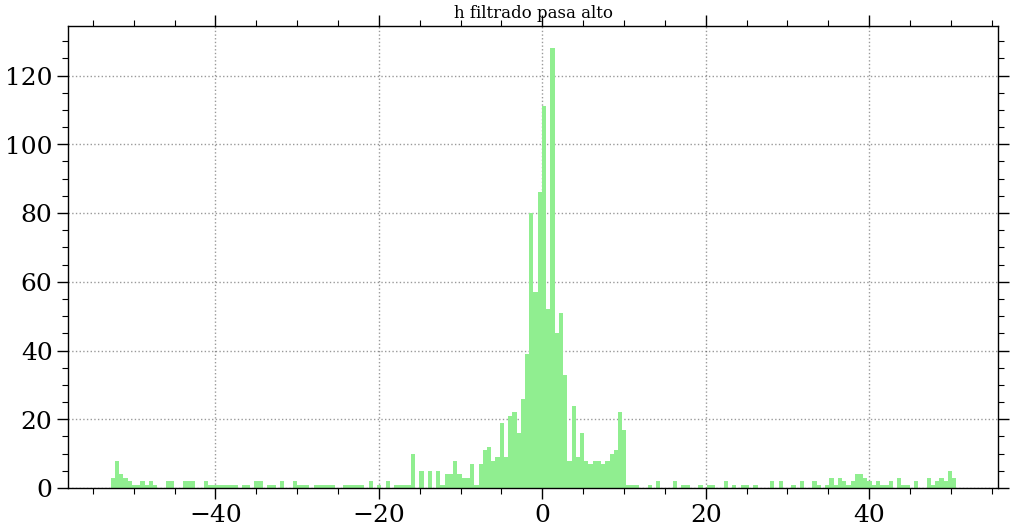

In [8]:
fig, ax = plt.subplots()
noise = highpass_h
ax.hist(noise,bins=200)
plt.title(f'h filtrado pasa alto')

Text(0, 0.5, 'FFT Amplitude |X(freq)|')

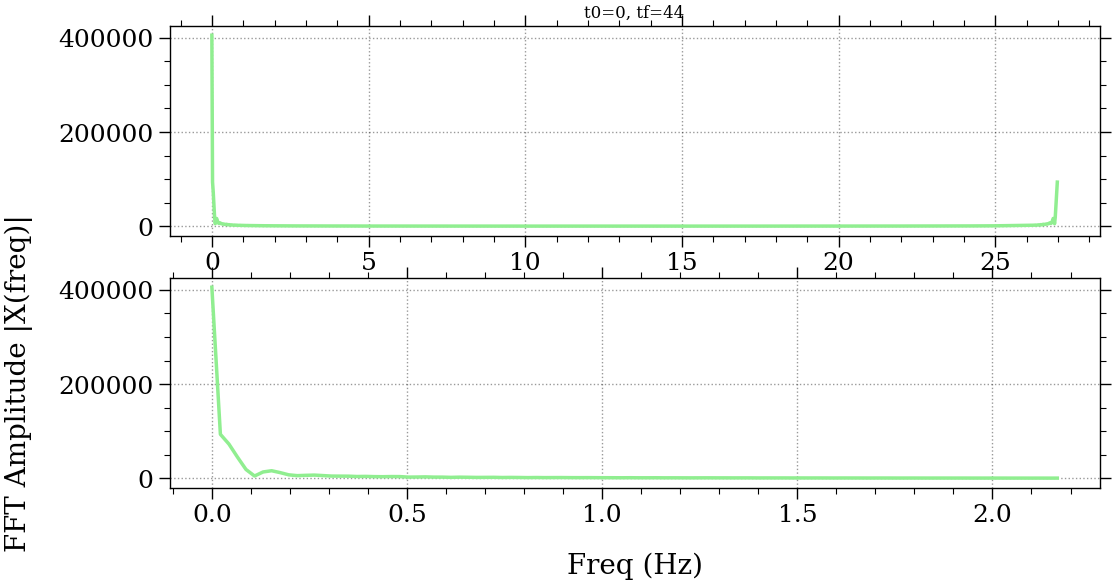

In [9]:
from scipy.fft import fft, ifft, fftfreq

fig, ax = plt.subplots(2,1)

hf = fft(h)
sampling_interval = t[-1]/len(t)
sr = int(1/sampling_interval)
N = len(hf)
n = np.arange(N)
T = N/sr
freq = n/T
ax[0].set_title(f't0={int(t[0])}, tf={int(t[-1])}')
ax[0].plot(freq,np.abs(hf))
ax[1].plot(freq[:100],np.abs(hf[:100]))
plt.xlabel('Freq (Hz)')
plt.ylabel('FFT Amplitude |X(freq)|')
# frequencies = fftfreq(len(h),samplerate)[0:N//2]

# hf_plot = 2/N*np.abs(hf)[:N//2]
# test = hf_plot[:100]
# plt.plot(frequencies,hf_plot)
# plt.xlim(0.1,.4)
# plt.ylim(0,40)

Text(0, 0.5, 'FFT Amplitude |X(freq)|')

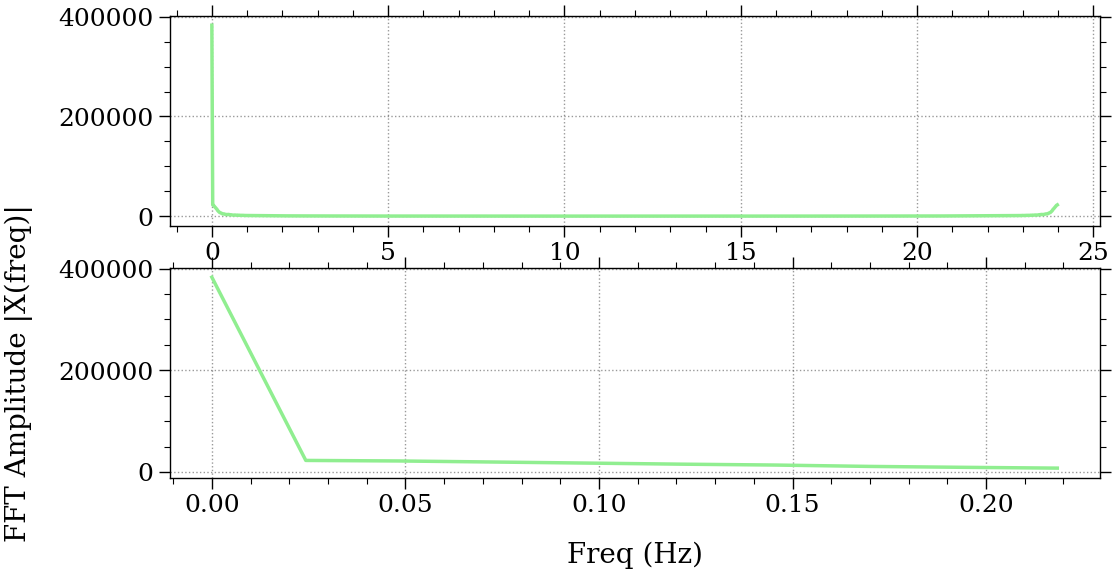

In [10]:
df = pd.read_csv(r'Mediciones\Clase 3\PID\PID-2-0.07-2-barrido.csv')
df = df[(df['Time'] > 7) & (df['Time'] < 40)]
t = df['Time'].values
h = df['Position'].values
I = df['I'].values
P = df['P'].values
D = df['D'].values

from scipy.fft import fft, ifft, fftfreq

fig, ax = plt.subplots(2,1)

hf = fft(h)
sampling_interval = t[-1]/len(t)
sr = int(1/sampling_interval)
N = len(hf)
n = np.arange(N)
T = N/sr
freq = n/T
ax[0].plot(freq,np.abs(hf))
ax[1].plot(freq[:10],np.abs(hf[:10]))
plt.xlabel('Freq (Hz)')
plt.ylabel('FFT Amplitude |X(freq)|')


24


Text(0.5, 1.0, 'Posición filtrada pasa altos')

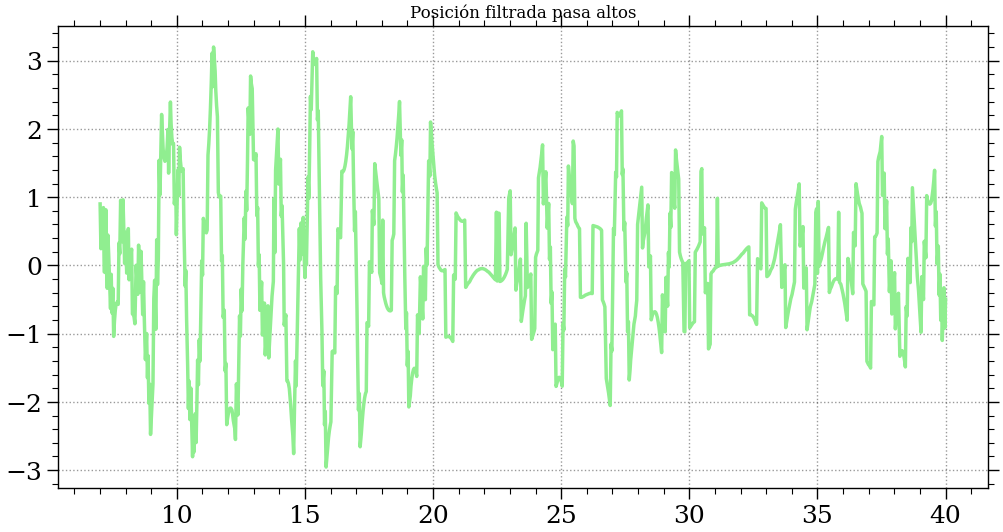

In [11]:
fs = int(len(t)/t[-1])
print(fs)
highpass_h = butter_highpass_filter(h,0.5,fs,2)
fig, ax = plt.subplots()
ax.plot(t,highpass_h)
ax.set_title(f'Posición filtrada pasa altos')

mu = 0.0037946223378599693
sigma = 1.1018484411615526


Text(0.5, 1.0, 'h filtrado pasa alto mu = 0,sigma = 1')

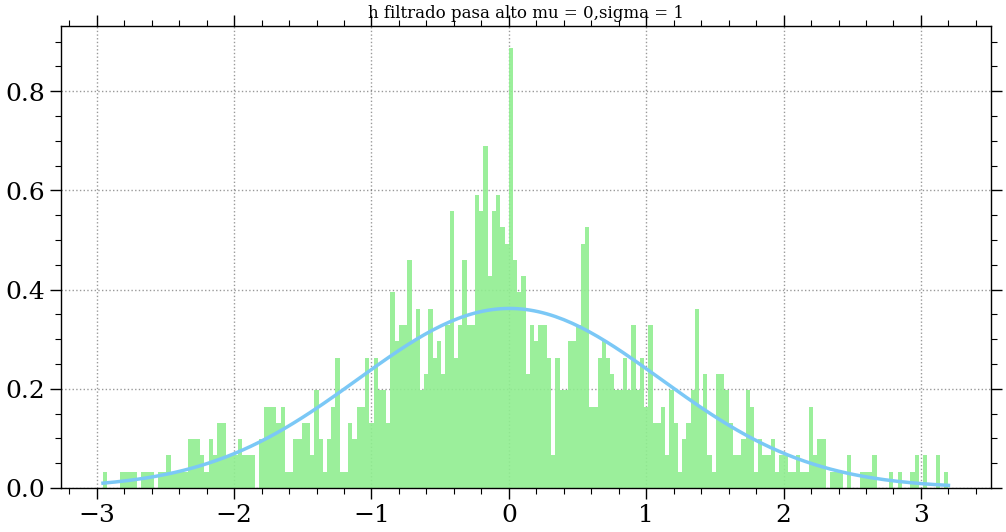

In [12]:
import statistics
from scipy.stats import norm

fig, ax = plt.subplots()
noise = highpass_h
mu, sigma = norm.fit(noise)
# noise = np.array([element for element in noise if (element > -15 and element < 15)])

_, bins, _ = plt.hist(noise, 200, density=True, alpha=0.9)
# ax.hist(noise,bins=200)
xmin,xmax = min(noise),max(noise)
# xmin,xmax = -15,15

best_fit_line = norm.pdf(bins, mu, sigma)
print(f'mu = {mu}')
print(f'sigma = {sigma}')
x = np.linspace(xmin,xmax,len(noise))
p = norm.pdf(x, mu, sigma)

ax.plot(bins, best_fit_line)

plt.title(f'h filtrado pasa alto mu = {int(mu)},sigma = {int(sigma)}')
# ax.plot(x,p)


In [13]:
from scipy.stats import norm
from scipy.optimize import curve_fit
import statsmodels.api as sm
fig, ax = plt.subplots()

h = np.sort(noise)

def funcion(h, sigma):
    return norm.pdf(h, loc=0, scale=sigma)
                    
p0 = [0, np.sum(h**2)/len(noise)]
popt, pcov = curve_fit(funcion,x,noise,p0=[sigma])
ym = funcion(x, popt[0])
ax.plot(x, ym,label='Best fit')
ax.hist(noise, 200, density=True, alpha=0.9)
ax.legend()
# sm.qqplot(h, line ='q')


ModuleNotFoundError: No module named 'statsmodels'

RESTA H-H(SUAVIZADO) Y DSP FILTRO PASA ALTOS

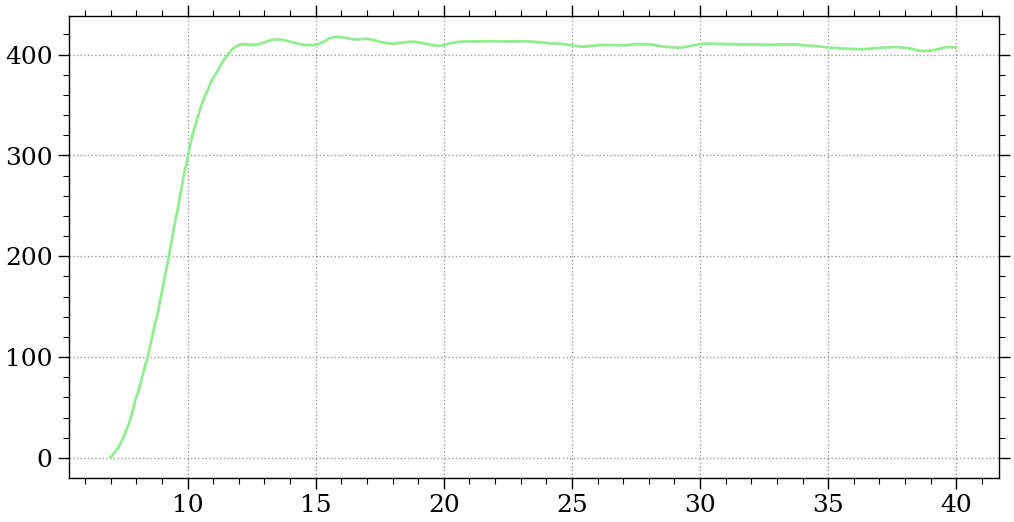

In [15]:
from scipy.signal import lfilter 

n = 30
b = [1.0 / n] * n
a = 1 
hh = lfilter(b, a, h)
plt.plot(t, hh, linewidth=2, linestyle="-")  # smooth by filter

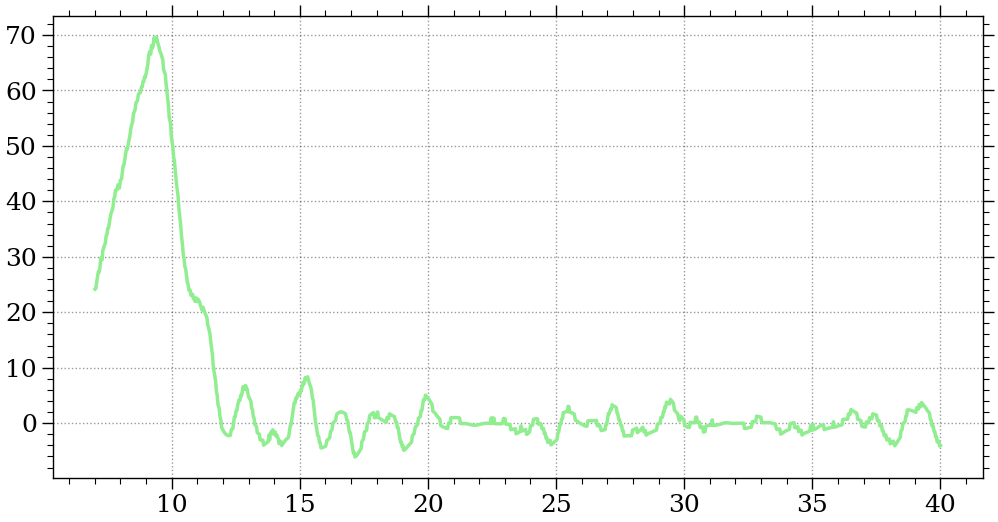

In [16]:
plt.plot(t,h-hh)

Text(0, 0.5, 'FFT Amplitude |X(freq)|')

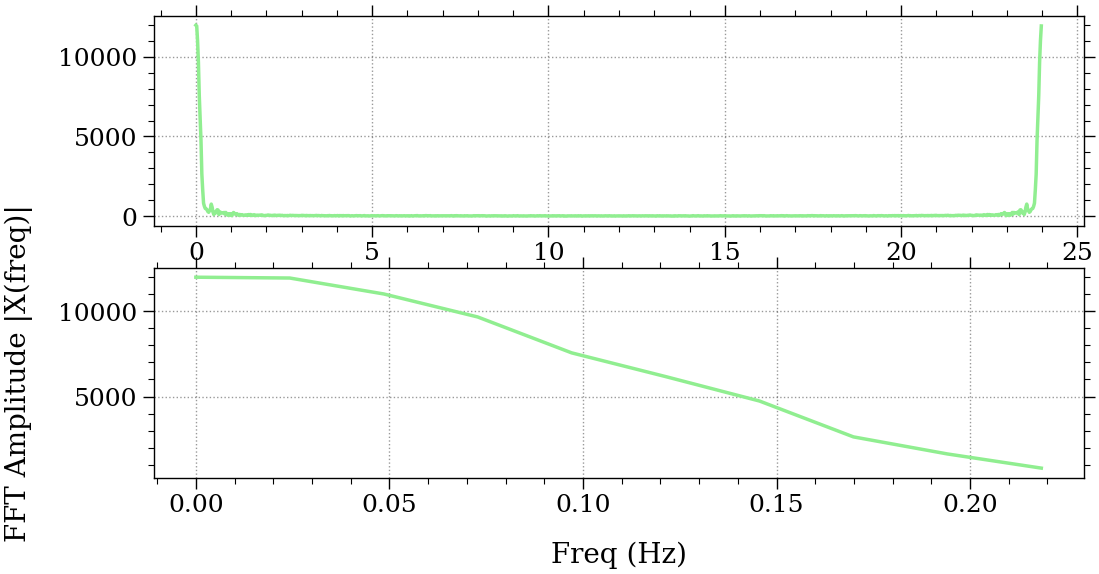

In [76]:
from scipy.fft import fft, ifft, fftfreq

fig, ax = plt.subplots(2,1)

hf = fft(h-hh)
sampling_interval = t[-1]/len(t)
sr = int(1/sampling_interval)
N = len(hf)
n = np.arange(N)
T = N/sr
freq = n/T
ax[0].plot(freq,np.abs(hf))
ax[1].plot(freq[:10],np.abs(hf[:10]))
plt.xlabel('Freq (Hz)')
plt.ylabel('FFT Amplitude |X(freq)|')

24


Text(0.5, 1.0, 'Posición filtrada pasa altos')

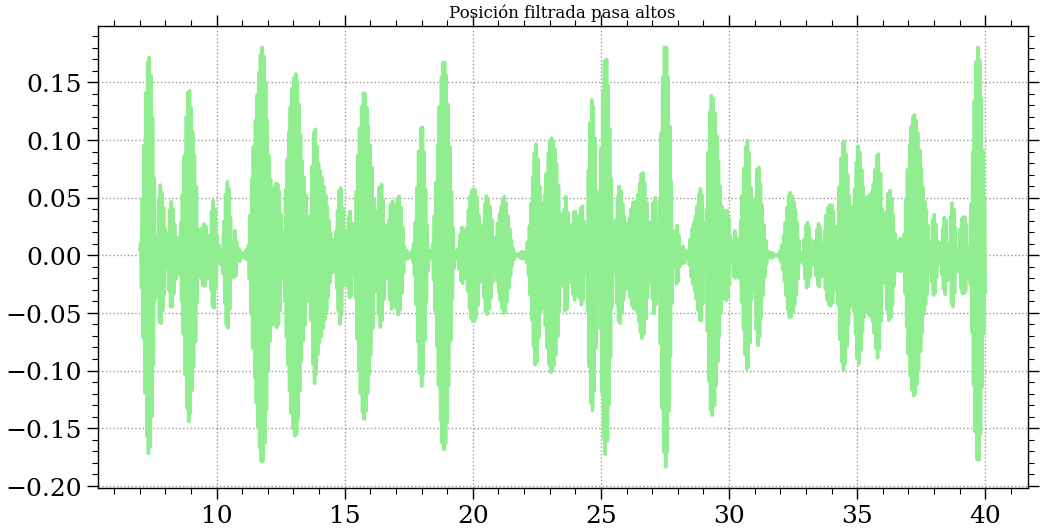

In [74]:
fs = int(len(t)/t[-1])
print(fs)
corte = 11
highpass_h = butter_highpass_filter(h-hh,corte,fs,2)
fig, ax = plt.subplots()
ax.plot(t,highpass_h)
ax.set_title(f'Posición filtrada pasa altos')

mu = -5.776998348899239e-06
sigma = 0.06828175979023751


Text(0.5, 1.0, '(h-hh) filtrado pasa alto $\\mu = -0.000\\ \\sigma = 0.068\\ frecuencia de corte = 11.000$')

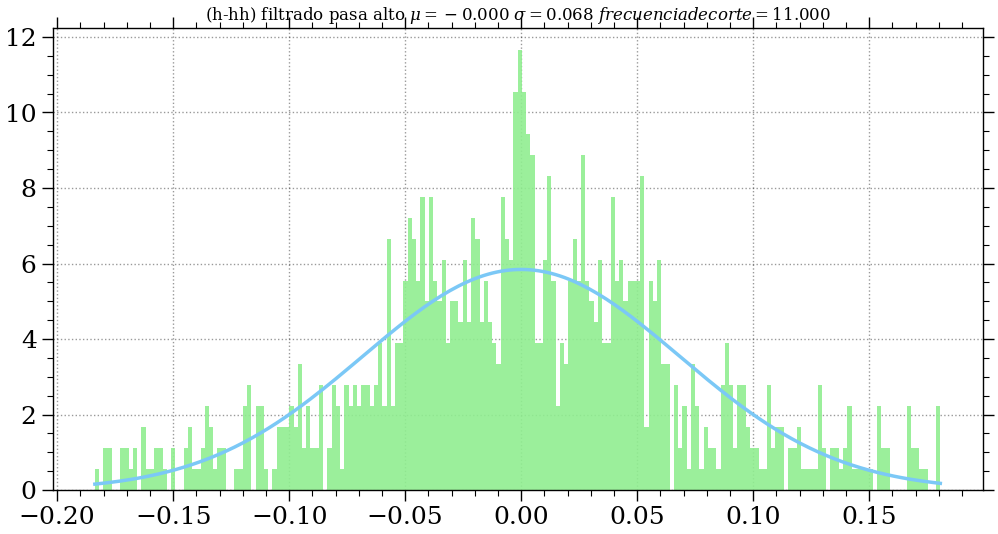

In [75]:
import statistics
from scipy.stats import norm

fig, ax = plt.subplots()
noise = highpass_h
mu, sigma = norm.fit(noise)
# noise = np.array([element for element in noise if (element > -15 and element < 15)])

_, bins, _ = plt.hist(noise, 200, density=True, alpha=0.9)
# ax.hist(noise,bins=200)
xmin,xmax = min(noise),max(noise)
# xmin,xmax = -15,15

best_fit_line = norm.pdf(bins, mu, sigma)
print(f'mu = {mu}')
print(f'sigma = {sigma}')
x = np.linspace(xmin,xmax,len(noise))
p = norm.pdf(x, mu, sigma)

ax.plot(bins, best_fit_line)

plt.title(f'(h-hh) filtrado pasa alto $\mu = {mu:.3f}\ \sigma = {sigma:.3f}\ frecuencia de corte = {corte:.3f}$')

Suavizar con Savitzky-Golay

749
749


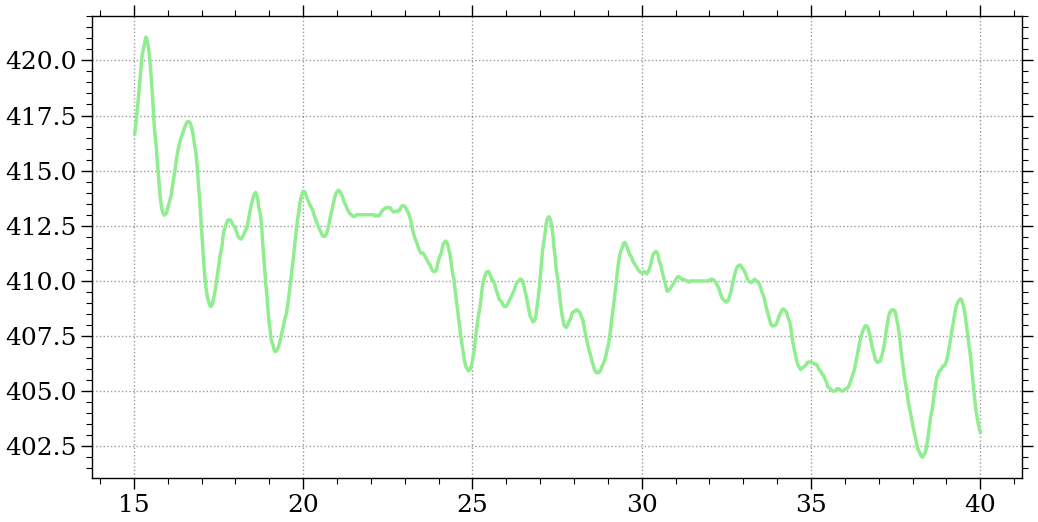

In [143]:
from scipy import signal

df = pd.read_csv(r'Mediciones\Clase 3\PID\PID-2-0.07-2-barrido.csv')
df = df[(df['Time'] > 15) & (df['Time'] < 40)]
t = df['Time'].values
h = df['Position'].values
I = df['I'].values
P = df['P'].values
D = df['D'].values

print(len(t))

hh_savgol = signal.savgol_filter(h,window_length=20, polyorder=3, mode="nearest")
print(len(h-hh_savgol))
plt.plot(t,hh_savgol)

Text(0, 0.5, 'FFT Amplitude |X(freq)|')

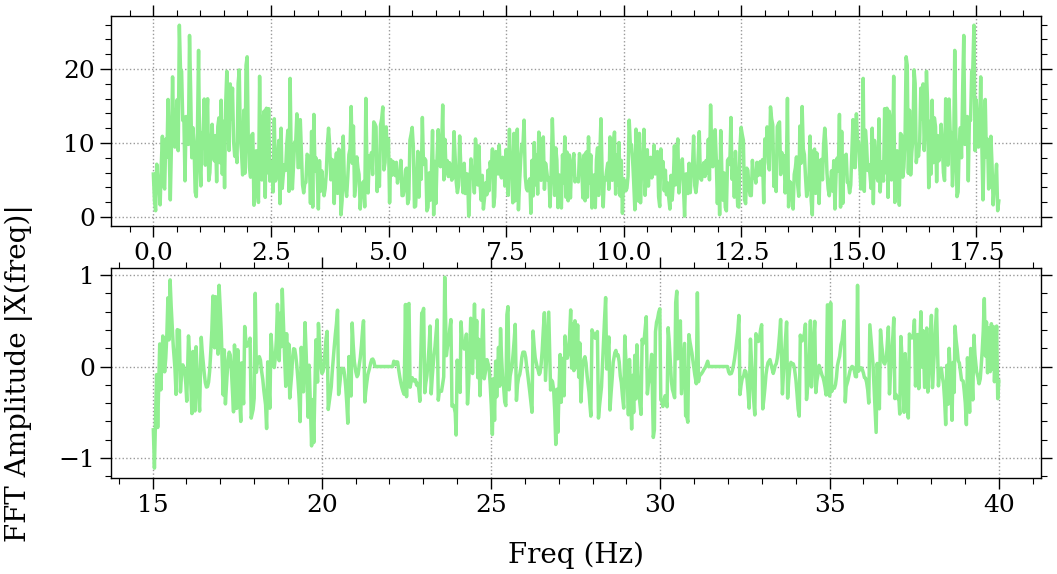

In [144]:
from scipy.fft import fft, ifft, fftfreq

fig, ax = plt.subplots(2,1)

hf = fft(h-hh_savgol)
sampling_interval = t[-1]/len(t)
sr = int(1/sampling_interval)
N = len(hf)
n = np.arange(N)
T = N/sr
freq = n/T
ax[0].plot(freq,np.abs(hf))
ax[1].plot(t,h-hh_savgol)
plt.xlabel('Freq (Hz)')
plt.ylabel('FFT Amplitude |X(freq)|')

18


Text(0.5, 1.0, 'Posición filtrada pasa altos')

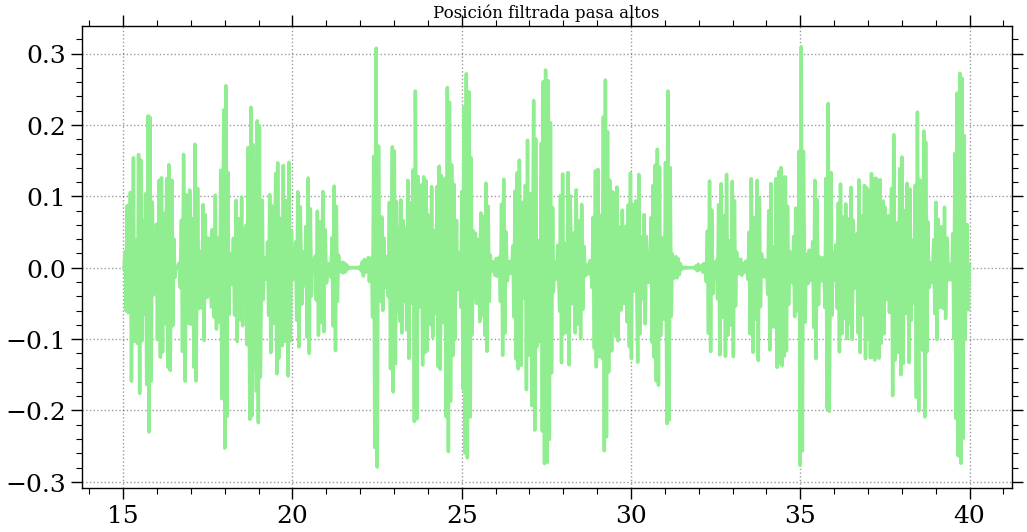

In [145]:
fs = int(len(t)/t[-1])
print(fs)
corte = 7
highpass_h = butter_highpass_filter(h-hh_savgol,corte,fs,2)
fig, ax = plt.subplots()
ax.plot(t,highpass_h)
ax.set_title(f'Posición filtrada pasa altos')

mu = -1.7647308602191506e-05
sigma = 0.10858992523124808


Text(0.5, 1.0, '(h-hh) filtrado pasa alto $\\mu = -0.000\\ \\sigma = 0.109\\ frecuencia de corte = 7.000$')

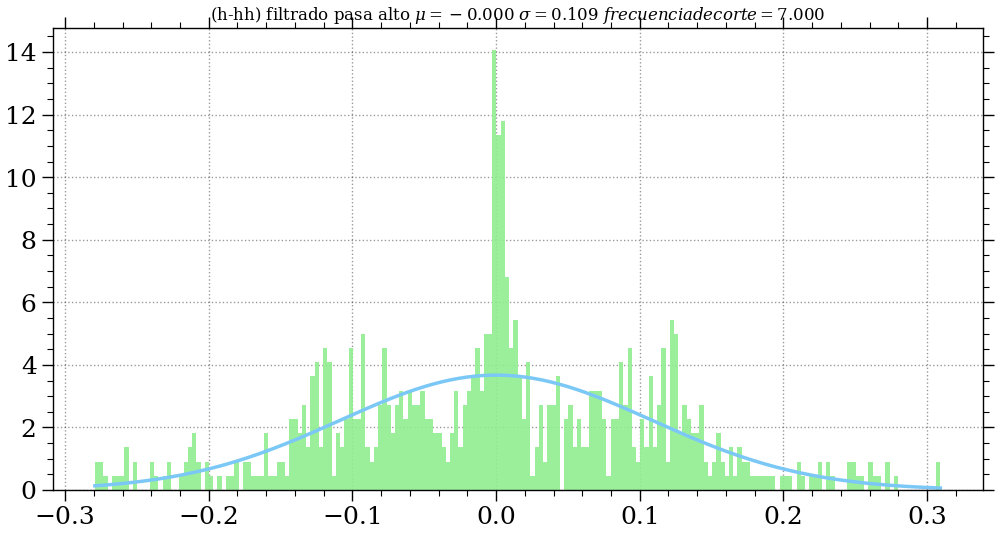

: 

In [146]:
import statistics
from scipy.stats import norm

fig, ax = plt.subplots()
noise = highpass_h
mu, sigma = norm.fit(noise)
# noise = np.array([element for element in noise if (element > -15 and element < 15)])

_, bins, _ = plt.hist(noise, 200, density=True, alpha=0.9)
# ax.hist(noise,bins=200)


best_fit_line = norm.pdf(bins, mu, sigma)
print(f'mu = {mu}')
print(f'sigma = {sigma}')

ax.plot(bins, best_fit_line)

plt.title(f'(h-hh) filtrado pasa alto $\mu = {mu:.3f}\ \sigma = {sigma:.3f}\ frecuencia de corte = {corte:.3f}$')

# EMPIEZO DE 0 POR LAS DUDAS

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, chi2
import pandas as pd
plt.style.use('informes.mplstyle')


df = pd.read_csv(r'Mediciones\Clase 3\PID\PID-2-0.07-2-barrido.csv')
df = df[(df['Time'] > 8) & (df['Time'] < 40)]
# df = df[df['Time'] < 40]

t = df['Time'].values
h = df['Position'].values

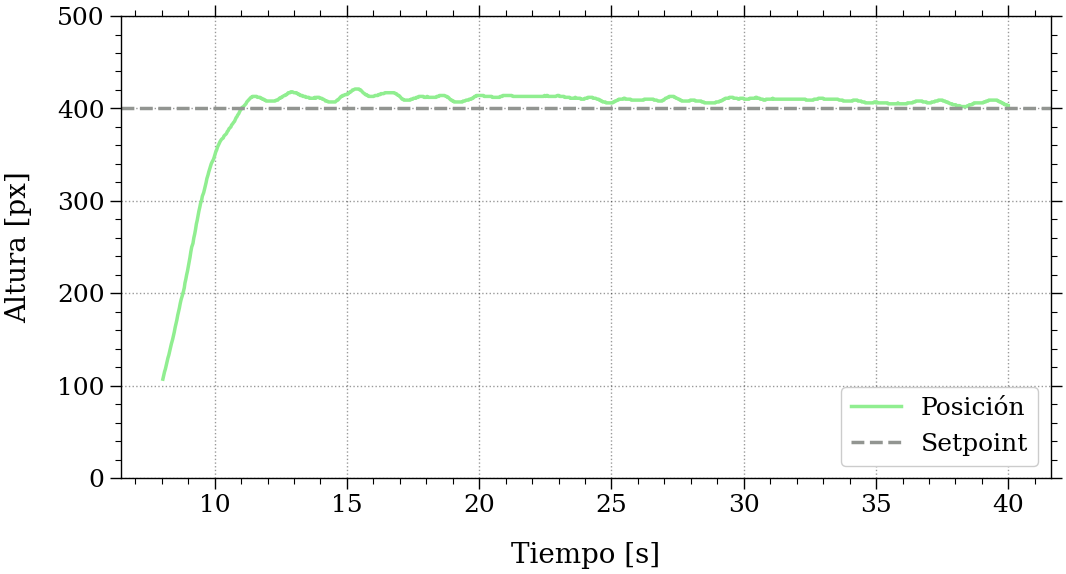

In [2]:
fig, ax = plt.subplots()
ax.set_xlabel('Tiempo [s]')
ax.set_ylabel('Altura [px]')
# ax.set_xlim(8, 40)
ax.set_ylim(0, 500)

ax.plot(t, h, label='Posición')
ax.axhline(400, c='C9', ls='--', label='Setpoint')


ax.legend(loc='lower right')
plt.show()

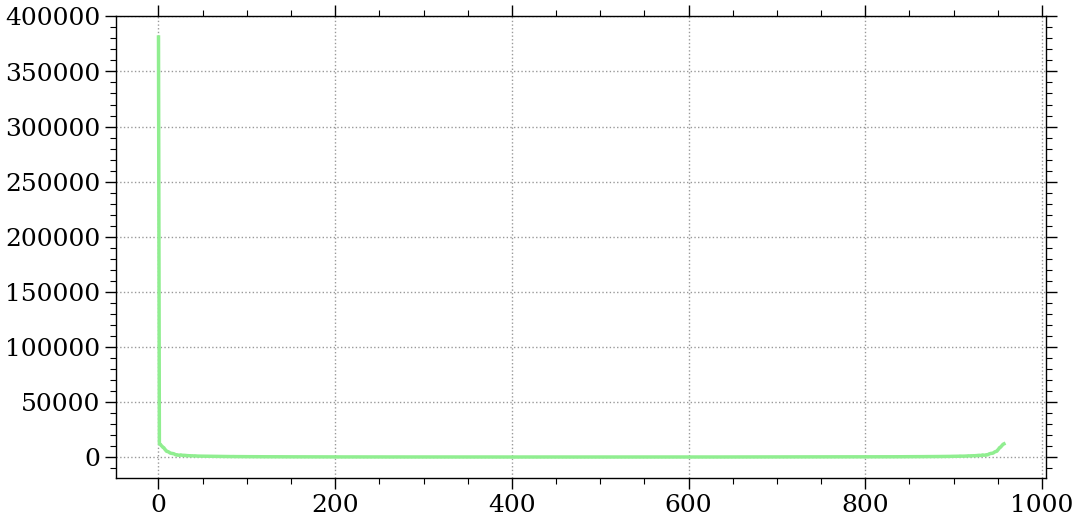

In [3]:
fig, ax = plt.subplots()

ax.plot(np.abs(np.fft.fft(h)))


plt.show()

In [4]:
from scipy.signal import butter,filtfilt
def butter_highpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype = "high", analog = False)
    return b, a

def butter_highpass_filter(data, cutoff, fs, order=5):
    b, a = butter_highpass(cutoff, fs, order=order)
    y = filtfilt(b, a, data)
    return y

fs = int(len(t)/t[-1])

0.3789983524429505 0.04522501348478905
16 30.395109591779384 0.016058107987782955
[ -0.69983272  -3.48946818   1.8349485    2.04989576  -0.47440264
   0.48164951  10.9513812    4.41843843  24.1850905   -0.31518662
 -20.98062143 -17.0748722  -15.81626902  10.29461676   5.13049277
  -3.65352151   3.45998897   6.66833904   0.54963457]


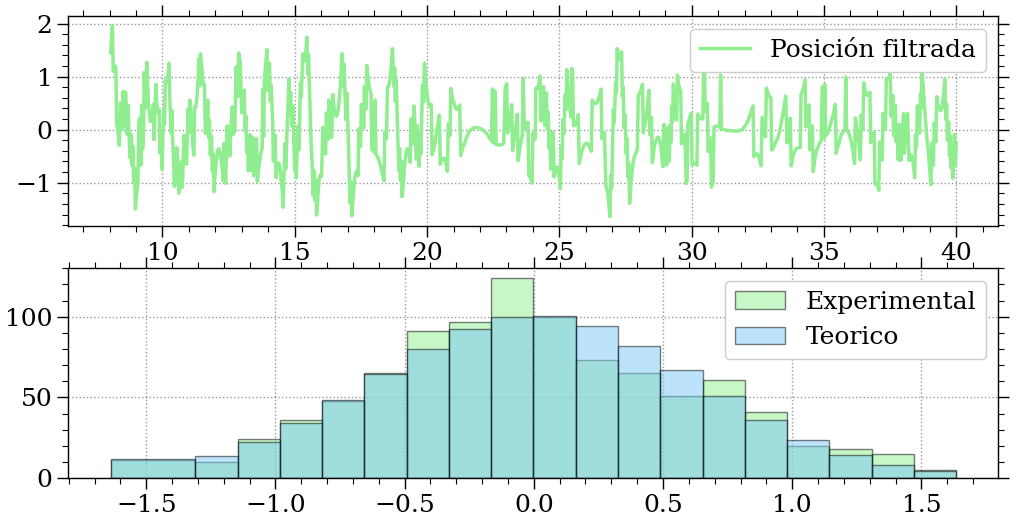

In [6]:
# Filtrado y desviacion estandar

w_0 = 0.75
high_h = butter_highpass_filter(h, w_0, fs, 2)
s_sq = np.sum(high_h**2)/len(high_h)
print(s_sq, s_sq*71/595)


# Correcion del bineado y valores teoricos

entr_temp, bins_temp = np.histogram(high_h, bins='auto')

bins = [bins_temp[0]]
counts = 0
for i in range(len(entr_temp)):
    counts += entr_temp[i]
    if counts >= 5:
        bins.append(bins_temp[i+1])
        counts = 0

w_bins = np.diff(bins)
entr = np.histogram(high_h, bins=bins)[0]
n_entr = np.sum(entr)

teo = np.diff(norm.cdf(bins, *norm.fit(high_h)))*n_entr


# Test chi cuadrado

df = len(entr) - 3

chisq = np.sum((entr - teo)**2 / teo)

P_chisq = 1 - chi2.cdf(chisq, df)

print(df, chisq, P_chisq)
print(entr - teo)


# Figura y plots

fig, ax = plt.subplots(2, 1)

ax[0].plot(t, high_h, label='Posición filtrada')
ax[1].bar(bins[:-1], entr, width=w_bins, align='edge', color='C0',
          ec='k', alpha=0.5, label='Experimental')
ax[1].bar(bins[:-1], teo, width=w_bins, align='edge', color='C1',
          ec='k', alpha=0.5, label='Teorico')


ax[0].legend()
ax[1].legend()
plt.show()